In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, Conv2D,
                                     Multiply, Reshape, BatchNormalization, MaxPooling2D)
from tensorflow.python.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import cv2

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [3]:
def spatial_attention(inputs):
    avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    attention = Conv2D(1, (7, 7), padding="same", activation="sigmoid")(concat)
    return Multiply()([inputs, attention])

In [4]:
def channel_attention(inputs):
    attention = GlobalAveragePooling2D()(inputs)
    attention = Dense(inputs.shape[-1] // 8, activation="relu")(attention)
    attention = Dense(inputs.shape[-1], activation="sigmoid")(attention)
    attention = Reshape((1, 1, inputs.shape[-1]))(attention)
    return Multiply()([inputs, attention])

In [5]:
def build_improved_densenet(input_shape=(224, 224, 3), num_classes=4):
    base_model = DenseNet121(include_top=False, weights="imagenet", input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Add attention mechanisms
    x = channel_attention(x)
    x = spatial_attention(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layers
    # x = Dense(128, activation="relu", kernel_regularizer=l2(1e-4))(x)
    # x = Dropout(0.7)(x)
    x = Dense(64, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.6)(x)

    # Output layer
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

In [6]:
def create_generators(train_dir, val_dir, test_dir, target_size=(224, 224), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        brightness_range=[0.7, 1.3],
        shear_range=0.2,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )

    return train_generator, val_generator, test_generator

In [7]:
def train_model(model, train_generator, val_generator, epochs=30, learning_rate=1e-4, patience=3):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="categorical_crossentropy",
                  metrics=["categorical_accuracy"])

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    )

    early_stop = EarlyStopping(
        monitor='val_loss',   # you can also monitor 'val_categorical_accuracy'
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )
    history = model.fit(train_generator, epochs=epochs, validation_data=val_generator,callbacks=[early_stop,reduce_lr])
    return history

In [8]:
def fine_tune_model(model, train_generator, val_generator, fine_tune_epochs=10, fine_tune_lr=1e-5):
    for layer in model.layers[:-100]:
        layer.trainable = False
    for layer in model.layers[-50:]:
        layer.trainable = True
    model.compile(optimizer=Adam(learning_rate=fine_tune_lr),
                  loss="categorical_crossentropy",
                  metrics=["categorical_accuracy"])
    history_fine = model.fit(train_generator, epochs=fine_tune_epochs, validation_data=val_generator)
    return history_fine

In [9]:
def evaluate_model(model, test_generator):
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [10]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["categorical_accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_categorical_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy Over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.title("Loss Over Epochs")
    plt.show()

In [11]:
def main():
    set_seed()

    # Define dataset paths
    dataset_path = r"C:\Users\User\Desktop\Diseases\Dataset"
    train_dir = os.path.join(dataset_path, "train")
    val_dir = os.path.join(dataset_path, "val")
    test_dir = os.path.join(dataset_path, "test")

    # Create data generators
    train_generator, val_generator, test_generator = create_generators(train_dir, val_dir, test_dir)

    # Build model
    model = build_improved_densenet()

    # Train model
    history = train_model(model, train_generator, val_generator)
    plot_history(history)

    # Fine-tune model
    history_fine = fine_tune_model(model, train_generator, val_generator)
    plot_history(history_fine)

    # Evaluate model
    evaluate_model(model, test_generator)

    # Save model
    model.save("eyenet_final_model_phase_b.h5")
    print("Model saved as eyenet_final_model_phase_b.h5")

Found 7489 images belonging to 4 classes.
Found 1499 images belonging to 4 classes.
Found 992 images belonging to 4 classes.
Epoch 1/30
235/235 [==============================] - 45s 178ms/step - loss: 1.2953 - categorical_accuracy: 0.3978 - val_loss: 0.9662 - val_categorical_accuracy: 0.6471 - lr: 1.0000e-04
Epoch 2/30
235/235 [==============================] - 40s 170ms/step - loss: 0.9231 - categorical_accuracy: 0.6308 - val_loss: 0.7590 - val_categorical_accuracy: 0.7265 - lr: 1.0000e-04
Epoch 3/30
235/235 [==============================] - 40s 170ms/step - loss: 0.8078 - categorical_accuracy: 0.6835 - val_loss: 0.6795 - val_categorical_accuracy: 0.7532 - lr: 1.0000e-04
Epoch 4/30
235/235 [==============================] - 40s 171ms/step - loss: 0.7375 - categorical_accuracy: 0.7140 - val_loss: 0.6490 - val_categorical_accuracy: 0.7592 - lr: 1.0000e-04
Epoch 5/30
235/235 [==============================] - 40s 171ms/step - loss: 0.6857 - categorical_accuracy: 0.7412 - val_loss: 0.60

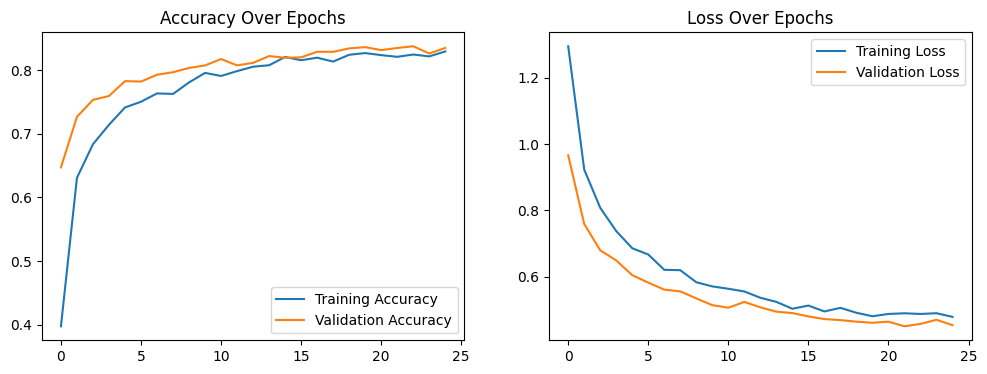

Epoch 1/10
235/235 [==============================] - 48s 179ms/step - loss: 0.4441 - categorical_accuracy: 0.8423 - val_loss: 0.3110 - val_categorical_accuracy: 0.8866
Epoch 2/10
235/235 [==============================] - 41s 173ms/step - loss: 0.3179 - categorical_accuracy: 0.8914 - val_loss: 0.2881 - val_categorical_accuracy: 0.9013
Epoch 3/10
235/235 [==============================] - 41s 175ms/step - loss: 0.2630 - categorical_accuracy: 0.9119 - val_loss: 0.2252 - val_categorical_accuracy: 0.9280
Epoch 4/10
235/235 [==============================] - 41s 176ms/step - loss: 0.2295 - categorical_accuracy: 0.9239 - val_loss: 0.2031 - val_categorical_accuracy: 0.9373
Epoch 5/10
235/235 [==============================] - 41s 175ms/step - loss: 0.1916 - categorical_accuracy: 0.9376 - val_loss: 0.1622 - val_categorical_accuracy: 0.9493
Epoch 6/10
235/235 [==============================] - 49s 210ms/step - loss: 0.1768 - categorical_accuracy: 0.9481 - val_loss: 0.1351 - val_categorical_acc

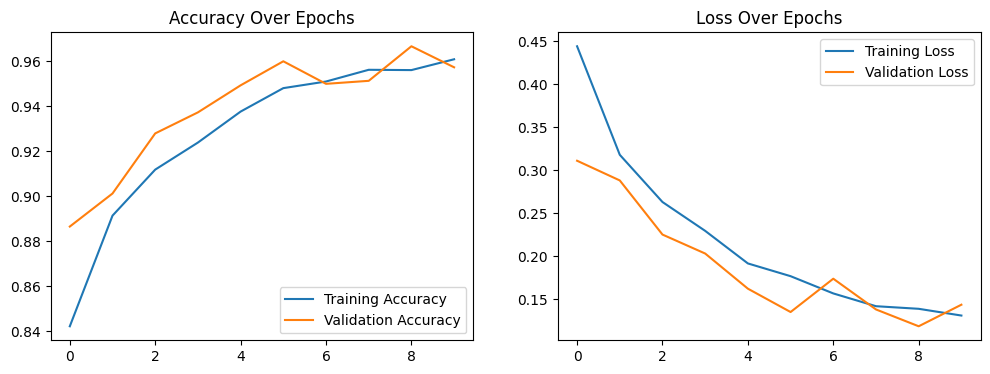

31/31 [==============================] - 1s 37ms/step - loss: 0.1261 - categorical_accuracy: 0.9667
Test Accuracy: 96.67%
31/31 [==============================] - 2s 35ms/step
                precision    recall  f1-score   support

      Cataract       0.99      0.93      0.96       243
Conjunctivitis       0.98      0.99      0.99       250
        Normal       0.91      1.00      0.95       248
          Stye       0.99      0.94      0.97       251

      accuracy                           0.97       992
     macro avg       0.97      0.97      0.97       992
  weighted avg       0.97      0.97      0.97       992



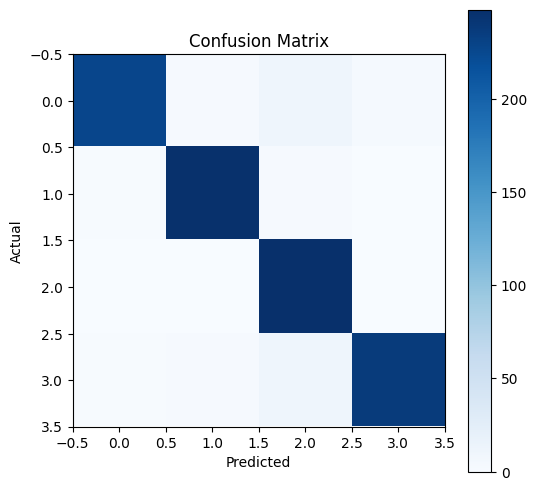

Model saved as eyenet_final_model_phase_b.h5


In [12]:
if __name__ == "__main__":
    main()